# Imports

In [1]:
import sys
import copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from model.base import CovidModel, SimulationParameters, set_parameters, normal_ci, logger
from utils import BasicStatistics, RemovePolicy, Propaganda, setup_city_layout, confidence_interval, AddPolicy
from model.utils import SocialPolicy
from model.debugutils import DebugUtils

# Simulation setup

To mimic data from Canada:

- Total number of days: 292
- Initial infection rate : kept at 0.01
- {'school_closing': {0: (0, 0.0), 3: (75, 8.7e-06), 2: (251, 0.0036092)}}
- {'workplace_closing': {0: (0, 0.0), 3: (77, 1.5e-05), 2: (173, 0.002742)}}

In [2]:
population_size = 10000
simulation_cycles = 292 # days
multiple_runs = 5
num_districts = 10

# Scenario 1 - Parameters settings

Default parameters. Unless explicitly overriden, these values are used in all scenarios

In [3]:
basic_parameters = SimulationParameters(
    social_policies = [
       SocialPolicy.LOCKDOWN_OFFICE,
       SocialPolicy.LOCKDOWN_FACTORY,
       SocialPolicy.LOCKDOWN_RETAIL,
       SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL,
       SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL,
       SocialPolicy.LOCKDOWN_HIGH_SCHOOL,
       SocialPolicy.SOCIAL_DISTANCING
    ],
    hospitalization_capacity = 0.1,
    icu_capacity = 0.01,
    mask_user_rate = 0.5,
    mask_efficacy = 0.4,
    imune_rate = 0.01,
    initial_infection_rate = 0.01,
    latency_period_shape = 3,
    latency_period_scale = 1, 
    incubation_period_shape = 6,
    incubation_period_scale = 1, 
    mild_period_duration_shape = 14,
    mild_period_duration_scale = 1,
    hospitalization_period_duration_shape = 12,
    hospitalization_period_duration_scale = 1,
    symptomatic_isolation_rate = 0.1,
    asymptomatic_contagion_probability = 0.1,
    risk_tolerance_mean = 0.5,
    risk_tolerance_stdev = 0.1,
    herding_behavior_mean = 0.5,
    herding_behavior_stdev = 0.1,
    allowed_restaurant_capacity = 1.0, # valid values: {1.0, 0.50, 0.25}
)

## Scenario 1 - Setup of monitored variables

In [4]:
sc = 1

basic_r0 = []
count_by_age_group = [[], [], [], [], [], [], [], [], [], []]
deaths_by_age_group = [[], [], [], [], [], [], [], [], [], []]
hospitalized_by_age_group = [[], [], [], [], [], [], [], [], [], []]
icu_by_age_group = [[], [], [], [], [], [], [], [], [], []]
deaths_total = []
hospitalized_total = []
icu_total = []
infected_per_day = {}
infected_per_day[sc] = []
for i in range(simulation_cycles):
    infected_per_day[sc].append([])
symptomatic_per_day = {}
symptomatic_per_day[sc] = []
for i in range(simulation_cycles):
    symptomatic_per_day[sc].append([])

# Scenario 1 - Run simulation multiple times

In [5]:
params = copy.deepcopy(basic_parameters)
set_parameters(params)
model = CovidModel()
setup_city_layout(model, population_size, num_districts=num_districts)

In [6]:
from model.location import District

In [7]:
[d for d in model.agents if isinstance(d, District)]

[
 Home district with 20 Buildings
 HomogeneousBuilding: 20 units (each with capacity for 5 people.) 16 allocated units with a total of 44 people.
 HomogeneousBuilding: 20 units (each with capacity for 5 people.) 20 allocated units with a total of 56 people.
 HomogeneousBuilding: 20 units (each with capacity for 5 people.) 17 allocated units with a total of 48 people.
 HomogeneousBuilding: 20 units (each with capacity for 5 people.) 20 allocated units with a total of 54 people.
 HomogeneousBuilding: 20 units (each with capacity for 5 people.) 20 allocated units with a total of 56 people.
 HomogeneousBuilding: 20 units (each with capacity for 5 people.) 12 allocated units with a total of 33 people.
 HomogeneousBuilding: 20 units (each with capacity for 5 people.) 20 allocated units with a total of 58 people.
 HomogeneousBuilding: 20 units (each with capacity for 5 people.) 20 allocated units with a total of 59 people.
 HomogeneousBuilding: 20 units (each with capacity for 5 people.) 17 

In [17]:
len([d for d in model.agents if isinstance(d, District)])

30

1/5
2/5
3/5
4/5
5/5
CPU times: user 53min 55s, sys: 1min 49s, total: 55min 44s
Wall time: 55min 44s


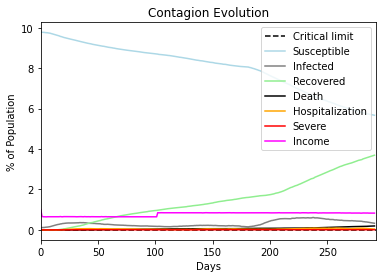

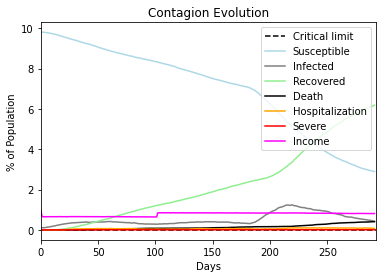

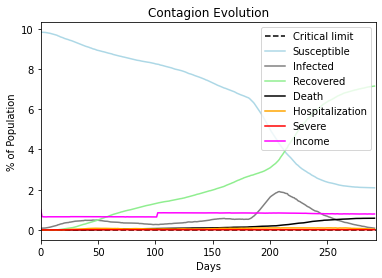

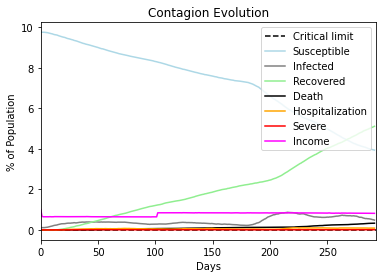

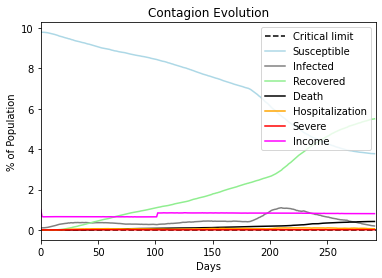

In [9]:
%%time

for k in range(multiple_runs):
    print(f"{k + 1}/{multiple_runs}")
    params = copy.deepcopy(basic_parameters)
    set_parameters(params)
    model = CovidModel()
    setup_city_layout(model, population_size, num_districts=num_districts)
#     model.add_listener(AddPolicy(model, SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, 75))
#     model.add_listener(AddPolicy(model, SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, 75))
#     model.add_listener(AddPolicy(model, SocialPolicy.LOCKDOWN_HIGH_SCHOOL, 75))
#     model.add_listener(RemovePolicy(model, SocialPolicy.LOCKDOWN_OFFICE, 100))
    model.add_listener(RemovePolicy(model, SocialPolicy.LOCKDOWN_FACTORY, 100))
#     model.add_listener(RemovePolicy(model, SocialPolicy.LOCKDOWN_RETAIL, 100))
    model.add_listener(RemovePolicy(model, SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, 180))
    model.add_listener(RemovePolicy(model, SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, 180))
    model.add_listener(RemovePolicy(model, SocialPolicy.LOCKDOWN_HIGH_SCHOOL, 180))
    statistics = BasicStatistics(model)
    model.add_listener(statistics)
    debug = DebugUtils(model)
    model.add_listener(debug)
    logger().model = model
    for i in range(simulation_cycles):
        model.step()
    debug.update_infection_status()
    basic_r0.append(debug.get_R0_stats()['infections'].mean())
    stats = debug.get_age_group_stats()
    infected = stats['infected'].sum() + stats['recovered'].sum()
    deaths_total.append(stats['deaths'].sum() / infected)
    hospitalized_total.append(stats['hospitalized'].sum() / infected)
    icu_total.append(stats['icu'].sum() / infected)
    for i in range(10):
        infected = stats['infected'][i] + stats['recovered'][i]
        deaths_by_age_group[i].append(0 if infected == 0 else stats['deaths'][i] / infected)
        hospitalized_by_age_group[i].append(0 if infected == 0 else stats['hospitalized'][i] / infected)
        icu_by_age_group[i].append(0 if infected == 0 else stats['icu'][i] / infected)
        count_by_age_group[i].append(stats['count'][i])
    for i in range(simulation_cycles):
        infected_per_day[sc][i].append(debug.new_infections[i + 1])
    new_symptomatics = debug.get_new_symptomatic_stats(simulation_cycles)
    for i in range(simulation_cycles):
        symptomatic_per_day[sc][i].append(new_symptomatics[i])
    statistics.export_chart(f'run_{sc}_{k}.png')
    statistics.export_csv(f'run_{sc}_{k}.csv')

# Scenario 1 - Print results

In [10]:
print(confidence_interval(basic_r0))

(2.7956986904884475, 3.115252432517592, 3.434806174546736)


In [11]:
for i in range(10):
    print(f"{i * 10} to {i * 10 + 9}: {confidence_interval(count_by_age_group[i])}")

0 to 9: (1111.4618908885504, 1153.4, 1195.3381091114497)
10 to 19: (2277.579444694441, 2332.4, 2387.220555305559)
20 to 29: (2239.6963139120035, 2306.6, 2373.5036860879964)
30 to 39: (1809.3679553213135, 1859.8, 1910.2320446786864)
40 to 49: (1240.4611187492112, 1263.4, 1286.338881250789)
50 to 59: (656.4658411137598, 692.0, 727.5341588862402)
60 to 69: (277.9213120822762, 296.6, 315.27868791772386)
70 to 79: (77.9123798720112, 84.4, 90.88762012798881)
80 to 89: (11.138410965710786, 15.2, 19.261589034289212)
90 to 99: (-0.280087380658257, 0.4, 1.0800873806582572)


In [12]:
print(f"Total: {confidence_interval(deaths_total)}")
for i in range(10):
    print(f"{i * 10} to {i * 10 + 9}: {confidence_interval(deaths_by_age_group[i])}")

Total: (0.047221963529698305, 0.06080247532997245, 0.07438298713024659)
0 to 9: (0.0003172778535196585, 0.001834487531120176, 0.0033516972087206933)
10 to 19: (0.0011904611704803836, 0.004236603669290044, 0.007282746168099704)
20 to 29: (0.01331072755387473, 0.02260460893567695, 0.03189849031747917)
30 to 39: (0.04968954356129261, 0.058343772454716815, 0.06699800134814102)
40 to 49: (0.07777142526259857, 0.10450309233196667, 0.13123475940133478)
50 to 59: (0.20245495950913908, 0.26364693968992986, 0.32483891987072067)
60 to 69: (0.3866125555973367, 0.47429319712250323, 0.5619738386476698)
70 to 79: (0.7421525547673148, 0.8422118363422711, 0.9422711179172275)
80 to 89: (0.7366521032236238, 0.85, 0.9633478967763761)
90 to 99: (0.0, 0.0, 0.0)


In [13]:
print(f"Total: {confidence_interval(hospitalized_total)}")
for i in range(10):
    print(f"{i * 10} to {i * 10 + 9}: {confidence_interval(hospitalized_by_age_group[i])}")

Total: (0.182353910718279, 0.2070685692412725, 0.23178322776426602)
0 to 9: (0.029404983494480688, 0.03979428649902576, 0.05018358950357084)
10 to 19: (0.07520400740495721, 0.0922453500926165, 0.1092866927802758)
20 to 29: (0.1494235901446696, 0.1664452086227457, 0.1834668271008218)
30 to 39: (0.22660438814509526, 0.25788629599375207, 0.2891682038424089)
40 to 49: (0.3017913674458048, 0.3457438901295145, 0.3896964128132242)
50 to 59: (0.47490286235003326, 0.5359631606996207, 0.5970234590492081)
60 to 69: (0.5938834247586166, 0.7330537210892195, 0.8722240174198225)
70 to 79: (0.7346355766368152, 0.8941343517430473, 1.0536331268492796)
80 to 89: (0.6649036596534801, 0.85, 1.0350963403465199)
90 to 99: (0.0, 0.0, 0.0)


In [14]:
print(f"Total: {confidence_interval(icu_total)}")
for i in range(10):
    print(f"{i * 10} to {i * 10 + 9}: {confidence_interval(icu_by_age_group[i])}")

Total: (0.025983106121673386, 0.03739896183406426, 0.04881481754645513)
0 to 9: (-0.00013627841277273254, 0.0017857177355149374, 0.003707713883802607)
10 to 19: (0.0007469760523729414, 0.0036442608284051547, 0.0065415456044373675)
20 to 29: (0.010779475260228964, 0.014297200106590632, 0.0178149249529523)
30 to 39: (0.025945395965359018, 0.0366949734945217, 0.04744455102368438)
40 to 49: (0.04223991445183592, 0.0706720156000609, 0.09910411674828587)
50 to 59: (0.09574144222182213, 0.15481999976910685, 0.21389855731639157)
60 to 69: (0.15729628316716293, 0.2900791953037722, 0.42286210744038144)
70 to 79: (0.32760982545371486, 0.41232916711177586, 0.49704850876983686)
80 to 89: (0.126858227719405, 0.29999999999999993, 0.47314177228059484)
90 to 99: (0.0, 0.0, 0.0)


# Plot results

## 10000 people, 10 districts

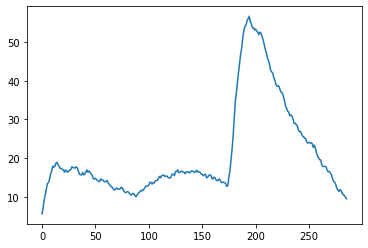

In [15]:
mean = np.mean(infected_per_day[1], axis=1)
stdev = np.std(infected_per_day[1], axis=1)
window = 7
ma_mean = np.convolve(mean, np.ones((window,))/window, mode='valid')
ma_stdev = np.convolve(stdev, np.ones((window,))/window, mode='valid')

plt.plot(ma_mean)

#plt.fill_between(range(3), mean-standard_dev, mean+standard_dev, alpha = 0.5)
plt.show()

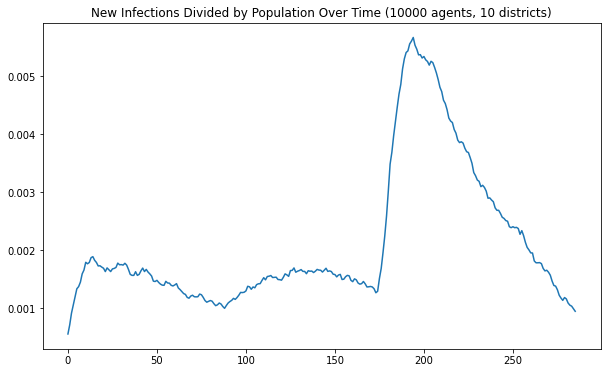

In [16]:
mean = np.mean(infected_per_day[1], axis=1)
stdev = np.std(infected_per_day[1], axis=1)
window = 7
ma_mean = np.convolve(mean, np.ones((window,))/window, mode='valid')
ma_stdev = np.convolve(stdev, np.ones((window,))/window, mode='valid')

plt.figure(figsize=(10,6))
plt.plot(ma_mean/population_size)
#plt.plot(ma_mean[:-70]/population_size)
plt.title("New Infections Divided by Population Over Time (10000 agents, 10 districts)")
plt.show()

____
### Previous results (don't run if you want to keep these)
____

## 2000 people, 1 district

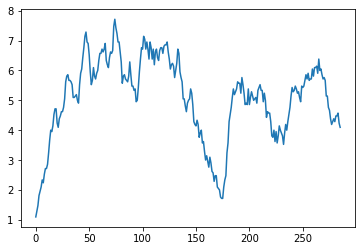

In [70]:
mean = np.mean(infected_per_day[1], axis=1)
stdev = np.std(infected_per_day[1], axis=1)
window = 7
ma_mean = np.convolve(mean, np.ones((window,))/window, mode='valid')
ma_stdev = np.convolve(stdev, np.ones((window,))/window, mode='valid')

plt.plot(ma_mean)

#plt.fill_between(range(3), mean-standard_dev, mean+standard_dev, alpha = 0.5)
plt.show()

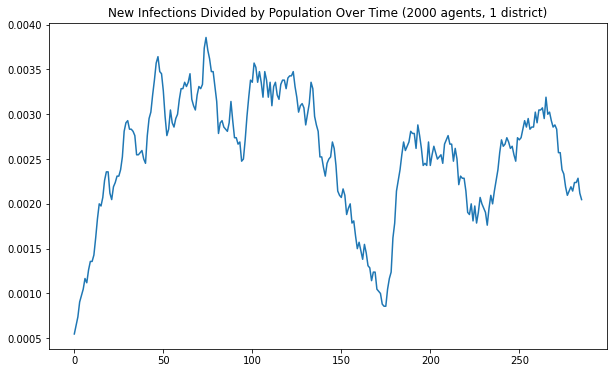

In [71]:
mean = np.mean(infected_per_day[1], axis=1)
stdev = np.std(infected_per_day[1], axis=1)
window = 7
ma_mean = np.convolve(mean, np.ones((window,))/window, mode='valid')
ma_stdev = np.convolve(stdev, np.ones((window,))/window, mode='valid')

plt.figure(figsize=(10,6))
plt.plot(ma_mean/population_size)
#plt.plot(ma_mean[:-70]/population_size)
plt.title("New Infections Divided by Population Over Time (2000 agents, 1 district)")
plt.show()

## 2000 people, 2 districts

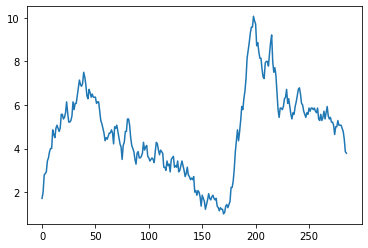

In [16]:
mean = np.mean(infected_per_day[1], axis=1)
stdev = np.std(infected_per_day[1], axis=1)
window = 7
ma_mean = np.convolve(mean, np.ones((window,))/window, mode='valid')
ma_stdev = np.convolve(stdev, np.ones((window,))/window, mode='valid')

plt.plot(ma_mean)

#plt.fill_between(range(3), mean-standard_dev, mean+standard_dev, alpha = 0.5)
plt.show()

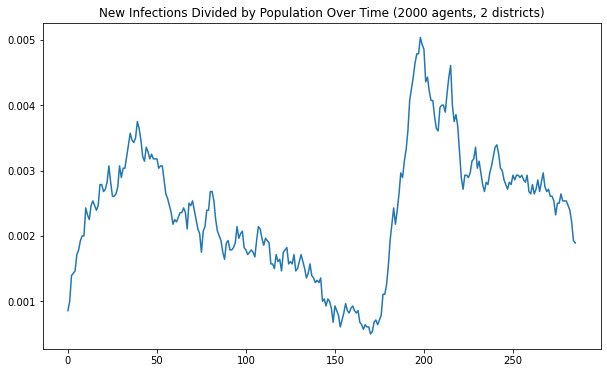

In [18]:
mean = np.mean(infected_per_day[1], axis=1)
stdev = np.std(infected_per_day[1], axis=1)
window = 7
ma_mean = np.convolve(mean, np.ones((window,))/window, mode='valid')
ma_stdev = np.convolve(stdev, np.ones((window,))/window, mode='valid')

plt.figure(figsize=(10,6))
plt.plot(ma_mean/population_size)
#plt.plot(ma_mean[:-70]/population_size)
plt.title("New Infections Divided by Population Over Time (2000 agents, 2 districts)")
plt.show()

## 2000 people, 4 districts

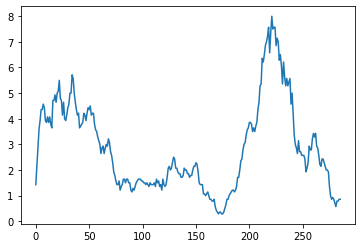

In [39]:
mean = np.mean(infected_per_day[1], axis=1)
stdev = np.std(infected_per_day[1], axis=1)
window = 7
ma_mean = np.convolve(mean, np.ones((window,))/window, mode='valid')
ma_stdev = np.convolve(stdev, np.ones((window,))/window, mode='valid')

plt.plot(ma_mean)

#plt.fill_between(range(3), mean-standard_dev, mean+standard_dev, alpha = 0.5)
plt.show()

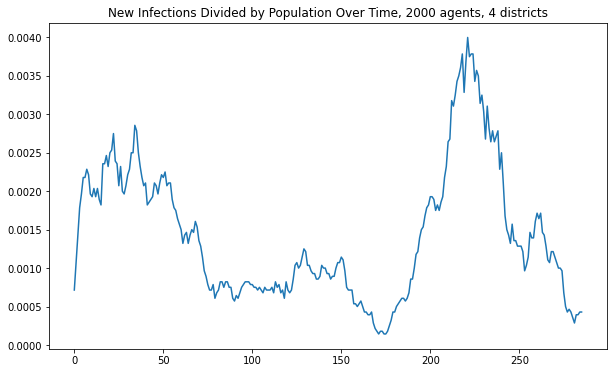

In [40]:
mean = np.mean(infected_per_day[1], axis=1)
stdev = np.std(infected_per_day[1], axis=1)
window = 7
ma_mean = np.convolve(mean, np.ones((window,))/window, mode='valid')
ma_stdev = np.convolve(stdev, np.ones((window,))/window, mode='valid')

plt.figure(figsize=(10,6))
plt.plot(ma_mean/population_size)
#plt.plot(ma_mean[:-70]/population_size)
plt.title("New Infections Divided by Population Over Time, 2000 agents, 4 districts")
plt.show()